In [339]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [340]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
import matplotlib.pyplot as plt
import numpy as np

In [341]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split(' ')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [342]:
all_X.condition.unique()

array(['50C', '25C'], dtype=object)

In [343]:
all_X.columns

Index(['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode', 'V_spike',
       'cooling_flag_1', 'cooling_flag_2', 'time_index', 'condition'],
      dtype='object')

In [344]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = ["open", "load", "antenna", "antenna+cooling*", "antenna+cooling**", "antenna+cooling", "cable+load", "cable+antenna", "cable+antenna+cooling" ]
    labels_50 = ["open", "load", "antenna", "antenna+cooling", "cable+load", "cable+antenna", "cable+antenna+cooling"]
    if cond == "25C":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "50C":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

for cond in all_X['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X[all_X['condition'] == cond]['class'].value_counts(dropna=False))



Condition: 50C
class
None                     515
cable+antenna+cooling    160
antenna+cooling          142
open                      62
antenna                   62
cable+load                62
cable+antenna             62
load                      61
Name: count, dtype: int64

Condition: 25C
class
None                     861
antenna+cooling**        129
antenna+cooling          129
cable+antenna+cooling    122
antenna+cooling*         102
cable+load                66
open                      65
load                      65
antenna                   65
cable+antenna             62
Name: count, dtype: int64


In [345]:
# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
for cond in all_X_clean['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 50C
class
cable+antenna+cooling    160
antenna+cooling          142
open                      62
antenna                   62
cable+load                62
cable+antenna             62
load                      61
Name: count, dtype: int64

Condition: 25C
class
antenna+cooling          129
cable+antenna+cooling    122
cable+load                66
open                      65
load                      65
antenna                   65
cable+antenna             62
Name: count, dtype: int64



Condition 25C - Data summary by class:
  open: 65 points, time range: 0.0 - 64.0 s
  load: 65 points, time range: 85.0 - 149.0 s
  antenna: 65 points, time range: 170.0 - 234.0 s
  cable+load: 66 points, time range: 255.0 - 320.0 s
  cable+antenna: 62 points, time range: 341.0 - 402.0 s
  antenna+cooling: 129 points, time range: 423.0 - 551.0 s
  cable+antenna+cooling: 122 points, time range: 572.0 - 693.0 s

Condition 50C - Data summary by class:
  open: 62 points, time range: 0.0 - 61.0 s
  load: 61 points, time range: 82.0 - 142.0 s
  antenna: 62 points, time range: 163.0 - 224.0 s
  cable+load: 62 points, time range: 245.0 - 306.0 s
  cable+antenna: 62 points, time range: 327.0 - 388.0 s
  antenna+cooling: 142 points, time range: 409.0 - 550.0 s
  cable+antenna+cooling: 160 points, time range: 571.0 - 730.0 s


/var/folders/ck/m95myx7x7575w886yq8txthr0000gn/T/ipykernel_28597/3356155261.py:86: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time, alpha=0.1, color='blue',
/var/folders/ck/m95myx7x7575w886yq8txthr0000gn/T/ipykernel_28597/3356155261.py:86: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time, alpha=0.1, color='blue',


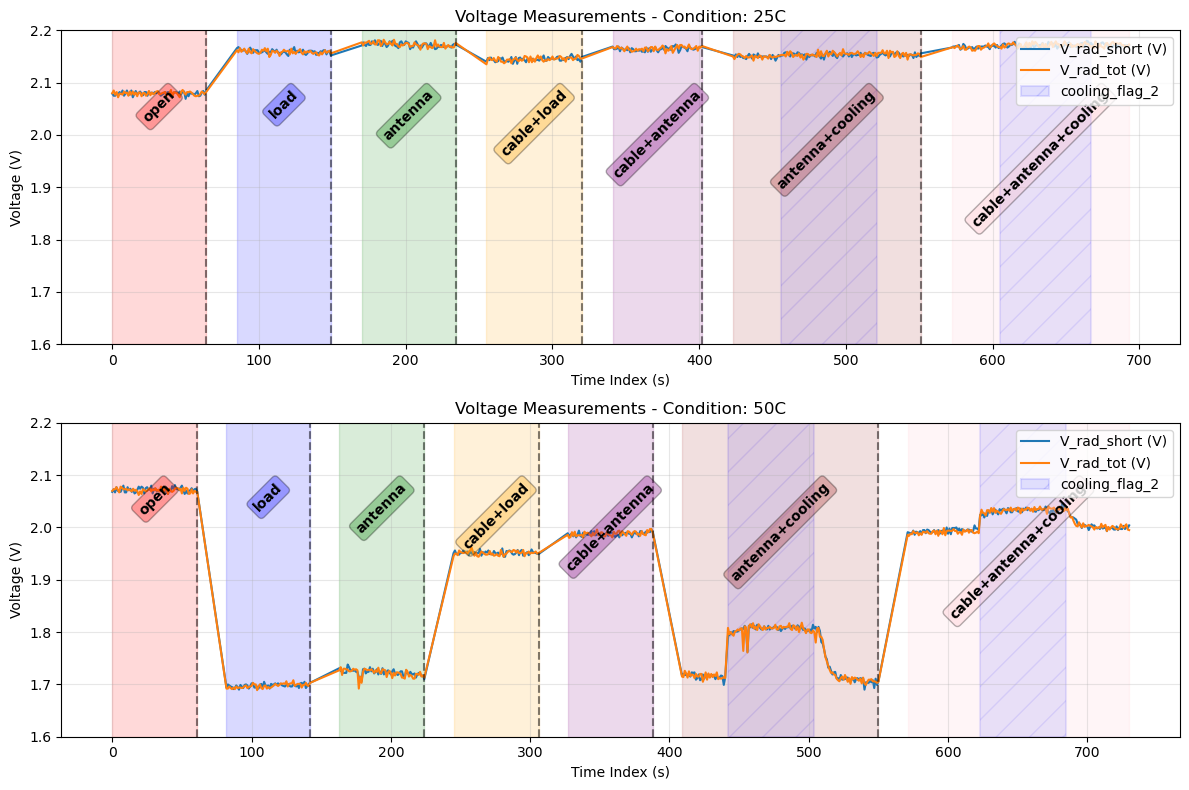

In [346]:
# Define class order and colors
class_order = ['open', 'load', 'antenna', 'cable+load', 'cable+antenna', 'antenna+cooling', 'cable+antenna+cooling']
class_colors = {
    'open': 'red',
    'load': 'blue', 
    'antenna': 'green',
    'cable+load': 'orange',
    'cable+antenna': 'purple',
    'antenna+cooling': 'brown',
    'cable+antenna+cooling': 'pink'
}

# Define voltage variables to plot
# variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
# variables = ['V_rad_short', 'V_rad_tot', 'V_housing', 'V_diode']
variables = ['V_rad_short', 'V_rad_tot']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

# Get unique conditions
conditions = sorted(all_X_clean['condition'].unique())

# Create subplots for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(6 * len(conditions), 8))
axes[0].set_ylim(1.6, 2.2)
axes[1].set_ylim(1.6, 2.2)
plt.ylim(1.6,2.2)
if len(conditions) == 1:
    axes = [axes]

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    
    # Filter data for this condition
    condition_data = all_X_clean[all_X_clean['condition'] == condition].copy()
    
    # Get available classes for this condition in order
    available_classes = [cls for cls in class_order if cls in condition_data['class'].unique()]
    
    # Create new time index with gaps between classes
    gap_duration = 20  # seconds between each class
    condition_data['time_index_2'] = 0.0
    current_time = 0
    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name].copy()
        
        if len(class_data) > 0:
            # Sort by original time_index to maintain chronological order
            class_data = class_data.sort_values('time_index')
            
            # Create new continuous time index for this class
            duration = len(class_data)
            new_time_indices = np.arange(current_time, current_time + duration)
            
            # Update the condition dataframe
            mask = condition_data['class'] == class_name
            condition_data.loc[mask, 'time_index_2'] = new_time_indices
            
            # Update current_time for next class (add duration + gap)
            current_time += duration + gap_duration
    
    # Sort data by time_index_2 for proper plotting
    data_sorted = condition_data.sort_values('time_index_2')
    
    # Plot each voltage variable
    for var in variables:
        ax.plot(data_sorted['time_index_2'], data_sorted[var] / 1000, label=labels[var])
    
    # Add blue shaded dashed areas for cooling_flag_2 == 1
    cooling_flag_2_data = data_sorted[data_sorted['cooling_flag_2'] == 1]
    if len(cooling_flag_2_data) > 0:
        # Group consecutive cooling periods
        cooling_flag_2_data = cooling_flag_2_data.copy()
        cooling_flag_2_data['group'] = (cooling_flag_2_data['time_index_2'].diff() > 1).cumsum()
        
        for group_id, group_data in cooling_flag_2_data.groupby('group'):
            start_time = group_data['time_index_2'].min()
            end_time = group_data['time_index_2'].max()
            
            # Add blue shaded area with dashed edges
            ax.axvspan(start_time, end_time, alpha=0.1, color='blue', 
                      edgecolor='blue', linewidth=1.5, hatch="/",
                      label='cooling_flag_2' if group_id == cooling_flag_2_data['group'].iloc[0] else "")
    
    # Add background colors and labels for each class    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            class_start = class_data['time_index_2'].min()
            class_end = class_data['time_index_2'].max()
            
            # Add background color for each class
            ax.axvspan(class_start, class_end, alpha=0.15, color=class_colors[class_name])
            
            # Add vertical line at the end of each class (except the last one)
            if class_name != available_classes[-1]:
                ax.axvline(class_end, color='black', linestyle='--', alpha=0.5)
            
            # Add text annotation for class name
            class_center = (class_start + class_end) / 2
            ax.text(class_center, ax.get_ylim()[1] * 0.95, class_name, 
                    ha='center', va='top', fontweight='bold', rotation=45,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[class_name], alpha=0.3))
    
    ax.set_title(f"Voltage Measurements - Condition: {condition}")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Voltage (V)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Print summary for this condition
    print(f"\nCondition {condition} - Data summary by class:")
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
            print(f"  {class_name}: {len(class_data)} points, time range: {time_range}")

plt.tight_layout()
plt.show()

In [347]:
# Calculate average V_rad_tot and V_housing for each condition and class
print("Average voltages by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_voltages = condition_data.groupby('class')[['V_rad_tot', 'V_housing']].mean()
    
    print("Microvolts:")
    print(avg_voltages.round(1))
    print("\nMillivolts:")
    print((avg_voltages / 1000).round(3))
    print("-" * 30)

Average voltages by condition and class:

Condition: 25C
Microvolts:
                       V_rad_tot  V_housing
class                                      
antenna                   2172.8      797.7
antenna+cooling           2153.1      785.7
cable+antenna             2165.4      796.4
cable+antenna+cooling     2170.7      797.5
cable+load                2144.9      794.5
load                      2158.8      791.6
open                      2079.3      783.9

Millivolts:
                       V_rad_tot  V_housing
class                                      
antenna                    2.173      0.798
antenna+cooling            2.153      0.786
cable+antenna              2.165      0.796
cable+antenna+cooling      2.171      0.798
cable+load                 2.145      0.794
load                       2.159      0.792
open                       2.079      0.784
------------------------------

Condition: 50C
Microvolts:
                       V_rad_tot  V_housing
class                  

## Calculating Temperatures

## Load

$$
T_{tissue} = \left( \frac{2 \cdot V_{rad-tot}-4 - RadOffset0 - RadOffsetchange \cdot T_{housing}}{Radslope0 + RadSlopeChange \cdot T_{housing}} \right) + T_{housing} = T_{rad}
$$

$$
 T_{housing} = \ V_{housing} \cdot HousingSlope + HousingOffset 
$$

## Antenna

$$ 
T_{tissue} = \frac{T_{rad}}{1- AL} - \frac{AL \cdot T_{antenna}}{1- AL} 
$$  

$$
T_{antenna} = \ V_{spike} \cdot AntennaSlope + AntennaOffset 
$$

## Load + Cable

$$ 
T_{tissue} = \frac{T_{rad}}{1- CL} - \frac{CL \cdot T_{cable}}{1- CL} 
$$ 

## Antenna + Cable

$$
T_{tissue} = \frac{1}{1- AL}\left(\frac{T_{rad} - T_{cable}\cdot CL}{1 - CL}\right) - \frac{AL \cdot T_{antenna}}{1- AL} 
$$

- RadSlopeChange: 0.0006182511106682944 V/°C²
- RadSlope0: -0.06051481175395883 V/°C
- RadOffsetChange: -0.0009632383570051569 V/°C
- RadOffset0: 0.2300154917793174 V
- HousingSlope: 98.08555780332561 °C/V
- HousingOffset: -49.81626782454236 °C

In [348]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

AL = 0.36  # Measured Antenna loss
CL = 0.44  # Measured Cable loss

# AL = 0.13  # Adjusted Antenna loss
# CL = 0.54  # Adjusted Cable loss


In [349]:
# Add columns to all_X_clean with None values if not already present
for col in ['T_tissue', 'T_rad', 'T_housing', 'T_antenna']:
    if col not in all_X_clean.columns:
        all_X_clean[col] = None

def T_housing_func(V_housing):
    return np.array(V_housing) * HousingSlope + HousingOffset

def T_rad_func(V_rad_tot, T_housing):
    return ((2 * np.array(V_rad_tot) - 4 - RadOffset0 - RadOffsetChange * np.array(T_housing)) /
            (RadSlope0 + RadSlopeChange * np.array(T_housing))) + np.array(T_housing)

# For each condition, calculate T_rad and T_housing for the "load" class
for cond in conditions:
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'load')
    df_cond = all_X_clean[mask]
    V_rad_tot = df_cond['V_rad_tot'] / 1000
    V_housing = df_cond['V_housing'] / 1000

    T_housing = T_housing_func(V_housing)
    T_rad = T_rad_func(V_rad_tot, T_housing)

    all_X_clean.loc[mask, 'T_rad'] = T_rad
    all_X_clean.loc[mask, 'T_tissue'] = T_rad
    all_X_clean.loc[mask, 'T_housing'] = T_housing


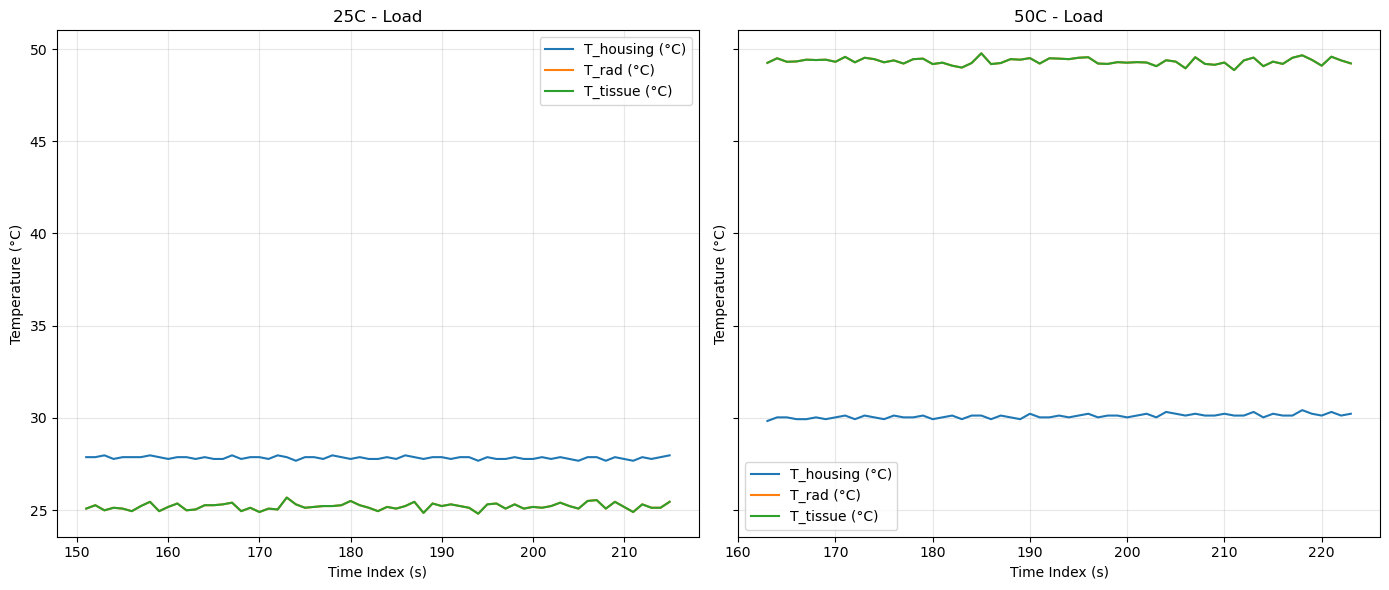

In [350]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_vars = ['T_housing', 'T_rad', 'T_tissue']
plot_labels = ['T_housing (°C)', 'T_rad (°C)', 'T_tissue (°C)']

for i, cond in enumerate(conditions):
    ax = axes[i]
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'load')
    df_cond = all_X_clean[mask]
    for var, label in zip(plot_vars, plot_labels):
        ax.plot(df_cond['time_index'], df_cond[var].astype(float), label=label)
    ax.set_title(f"{cond} - Load")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [351]:
# Calculate AntennaSlope and AntennaOffset
# Get mean V_spike for 25C antenna data
mask_25C = (all_X_clean['condition'] == '25C') & (all_X_clean['class'] == 'antenna')
V_spike_25C = all_X_clean[mask_25C]['V_diode'].mean() / 1000  # Convert to volts

# Get mean V_spike for 50C antenna data
mask_50C = (all_X_clean['condition'] == '50C') & (all_X_clean['class'] == 'antenna')
V_spike_50C = all_X_clean[mask_50C]['V_diode'].mean() / 1000  # Convert to volts

# Calculate slope and offset using two points: (V_spike_25C, 25) and (V_spike_50C, 50)
AntennaSlope = (50 - 25) / (V_spike_50C - V_spike_25C)
AntennaOffset = 25 - AntennaSlope * V_spike_25C

print(f"V_spike_25C = {V_spike_25C:.6f} V")
print(f"V_spike_50C = {V_spike_50C:.6f} V")
print(f"AntennaSlope = {AntennaSlope:.6f} °C/V")
print(f"AntennaOffset = {AntennaOffset:.6f} °C")

V_spike_25C = 0.112492 V
V_spike_50C = 0.009484 V
AntennaSlope = -242.698567 °C/V
AntennaOffset = 52.301722 °C


In [352]:
# Refactored temperature calculations for antenna class using arrays/lists

# Define equations for arrays
import numpy as np

def T_antenna_func(V_spike):
    return AntennaSlope * np.array(V_spike) + AntennaOffset

def T_tissue_antenna_func(T_rad, T_antenna):
    return np.array(T_rad) / (1 - AL) - (AL * np.array(T_antenna)) / (1 - AL)

# Select antenna class data
for cond in conditions:
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'antenna')
    df_antenna = all_X_clean[mask]
    if len(df_antenna) == 0:
        continue
    V_spike = df_antenna['V_diode'].values / 1000
    V_rad_tot = df_antenna['V_rad_tot'].values / 1000
    V_housing = df_antenna['V_housing'].values / 1000
    T_housing = T_housing_func(V_housing)
    T_rad = T_rad_func(V_rad_tot, T_housing)
    T_antenna = T_antenna_func(V_spike)
    T_tissue = T_tissue_antenna_func(T_rad, T_antenna)
    # Update all_X_clean columns
    all_X_clean.loc[mask, 'T_rad'] = T_rad
    all_X_clean.loc[mask, 'T_tissue'] = T_tissue
    all_X_clean.loc[mask, 'T_housing'] = T_housing
    all_X_clean.loc[mask, 'T_antenna'] = T_antenna

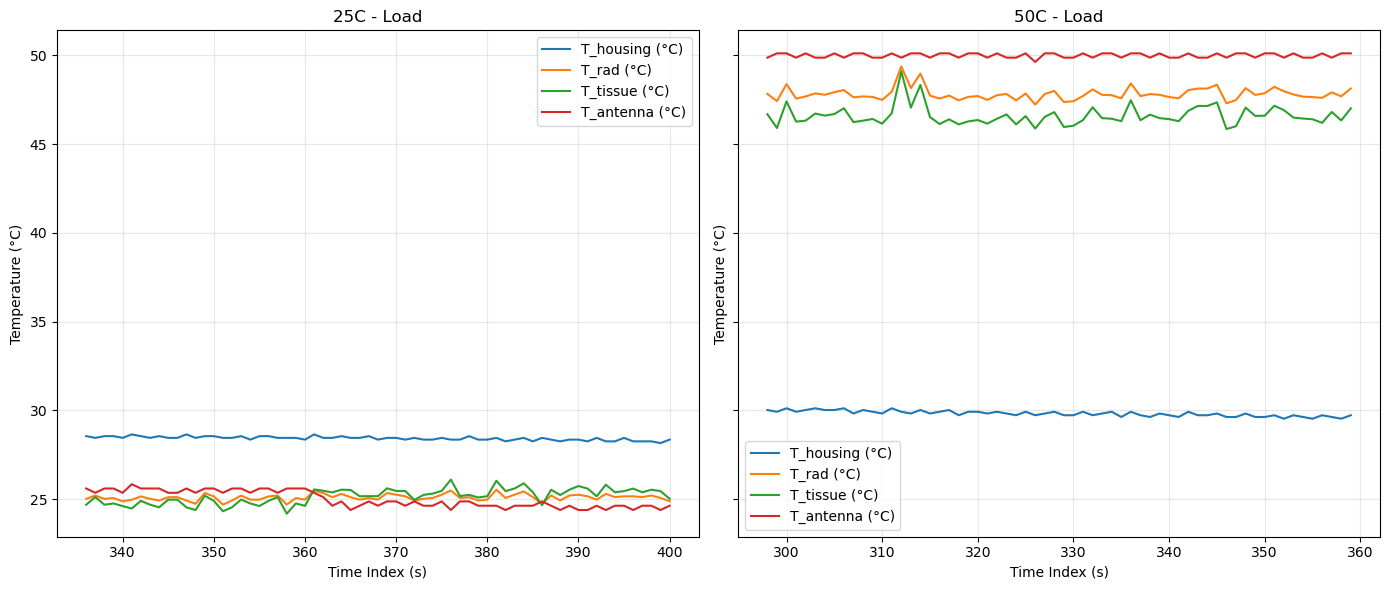

In [353]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_vars = ['T_housing', 'T_rad', 'T_tissue', 'T_antenna']
plot_labels = ['T_housing (°C)', 'T_rad (°C)', 'T_tissue (°C)', 'T_antenna (°C)']

for i, cond in enumerate(conditions):
    ax = axes[i]
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'antenna')
    df_cond = all_X_clean[mask]
    for var, label in zip(plot_vars, plot_labels):
        ax.plot(df_cond['time_index'], df_cond[var].astype(float), label=label)
    ax.set_title(f"{cond} - Load")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [354]:
for cond in conditions:
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'antenna+cooling')
    df_antenna = all_X_clean[mask]
    if len(df_antenna) == 0:
        continue
    V_spike = df_antenna['V_diode'].values / 1000
    V_rad_tot = df_antenna['V_rad_tot'].values / 1000
    V_housing = df_antenna['V_housing'].values / 1000
    T_housing = T_housing_func(V_housing)
    T_rad = T_rad_func(V_rad_tot, T_housing)
    T_antenna = T_antenna_func(V_spike)
    T_tissue = T_tissue_antenna_func(T_rad, T_antenna)
    # Update all_X_clean columns
    all_X_clean.loc[mask, 'T_rad'] = T_rad
    all_X_clean.loc[mask, 'T_tissue'] = T_tissue
    all_X_clean.loc[mask, 'T_housing'] = T_housing
    all_X_clean.loc[mask, 'T_antenna'] = T_antenna

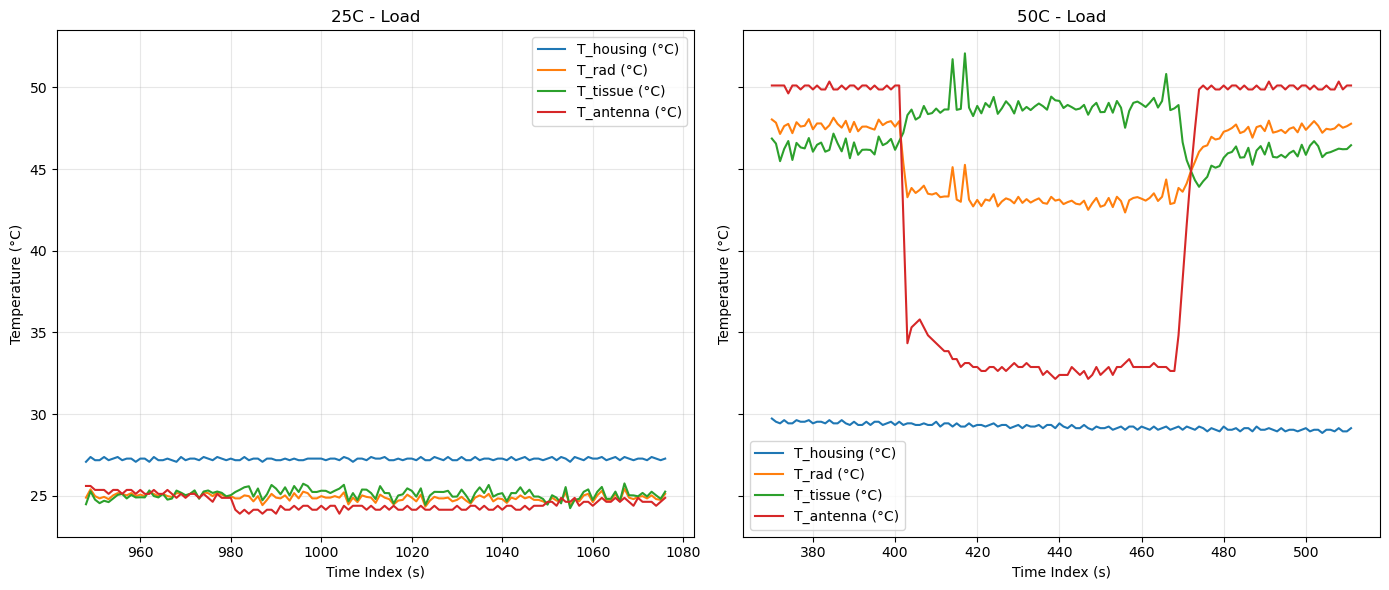

In [355]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_vars = ['T_housing', 'T_rad', 'T_tissue', 'T_antenna']
plot_labels = ['T_housing (°C)', 'T_rad (°C)', 'T_tissue (°C)', 'T_antenna (°C)']

for i, cond in enumerate(conditions):
    ax = axes[i]
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'antenna+cooling')
    df_cond = all_X_clean[mask]
    for var, label in zip(plot_vars, plot_labels):
        ax.plot(df_cond['time_index'], df_cond[var].astype(float), label=label)
    ax.set_title(f"{cond} - Load")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [356]:
# Refactored temperature calculations for antenna class using arrays/lists
def T_tissue_cable_func(T_rad, T_cable=27):
    return np.array(T_rad) / (1 - CL) - (CL * T_cable) / (1 - CL)

# Select antenna class data
for cond in conditions:
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'cable+load')
    df_antenna = all_X_clean[mask]
    if len(df_antenna) == 0:
        continue
    # V_spike = df_antenna['V_spike'].values / 1000
    V_rad_tot = df_antenna['V_rad_tot'].values / 1000
    V_housing = df_antenna['V_housing'].values / 1000
    T_housing = T_housing_func(V_housing)
    T_rad = T_rad_func(V_rad_tot, T_housing)
    T_antenna = T_antenna_func(V_spike)
    T_tissue = T_tissue_cable_func(T_rad)
    # Update all_X_clean columns
    all_X_clean.loc[mask, 'T_rad'] = T_rad
    all_X_clean.loc[mask, 'T_tissue'] = T_tissue
    all_X_clean.loc[mask, 'T_housing'] = T_housing
    # all_X_clean.loc[mask, 'T_antenna'] = T_antenna



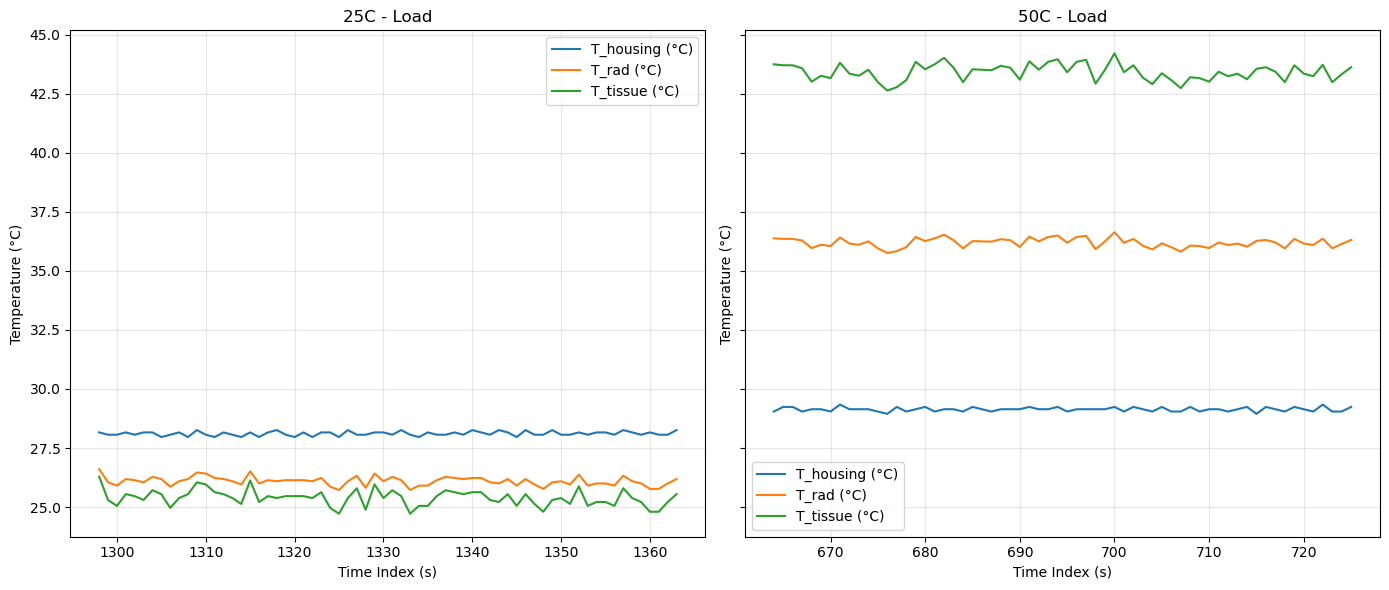

In [357]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_vars = ['T_housing', 'T_rad', 'T_tissue',]
plot_labels = ['T_housing (°C)', 'T_rad (°C)', 'T_tissue (°C)', 'T_antenna (°C)']

for i, cond in enumerate(conditions):
    ax = axes[i]
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'cable+load')
    df_cond = all_X_clean[mask]
    for var, label in zip(plot_vars, plot_labels):
        ax.plot(df_cond['time_index'], df_cond[var].astype(float), label=label)
    ax.set_title(f"{cond} - Load")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [358]:
# Refactored temperature calculations for cable+antenna class using arrays/lists

def T_tissue_cable_antenna_func(T_rad, T_antenna, T_cable=27):
    # Equation: T_tissue = (1/(1-AL)) * ((T_rad - T_cable*CL)/(1-CL)) - (AL*T_antenna)/(1-AL)
    return (1/(1-AL)) * ((np.array(T_rad) - T_cable*CL)/(1-CL)) - (AL*np.array(T_antenna))/(1-AL)

for cond in conditions:
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'cable+antenna')
    df_cable_antenna = all_X_clean[mask]
    if len(df_cable_antenna) == 0:
        continue
    V_spike = df_cable_antenna['V_diode'].values / 1000
    V_rad_tot = df_cable_antenna['V_rad_tot'].values / 1000
    V_housing = df_cable_antenna['V_housing'].values / 1000
    V_cable = df_cable_antenna['V_cable'].values / 1000 if 'V_cable' in df_cable_antenna.columns else V_housing

    T_housing = T_housing_func(V_housing)
    T_rad = T_rad_func(V_rad_tot, T_housing)
    T_antenna = T_antenna_func(V_spike)
    T_tissue = T_tissue_cable_antenna_func(T_rad, T_antenna)

    # Update all_X_clean columns
    all_X_clean.loc[mask, 'T_rad'] = T_rad
    all_X_clean.loc[mask, 'T_tissue'] = T_tissue
    all_X_clean.loc[mask, 'T_housing'] = T_housing
    all_X_clean.loc[mask, 'T_antenna'] = T_antenna

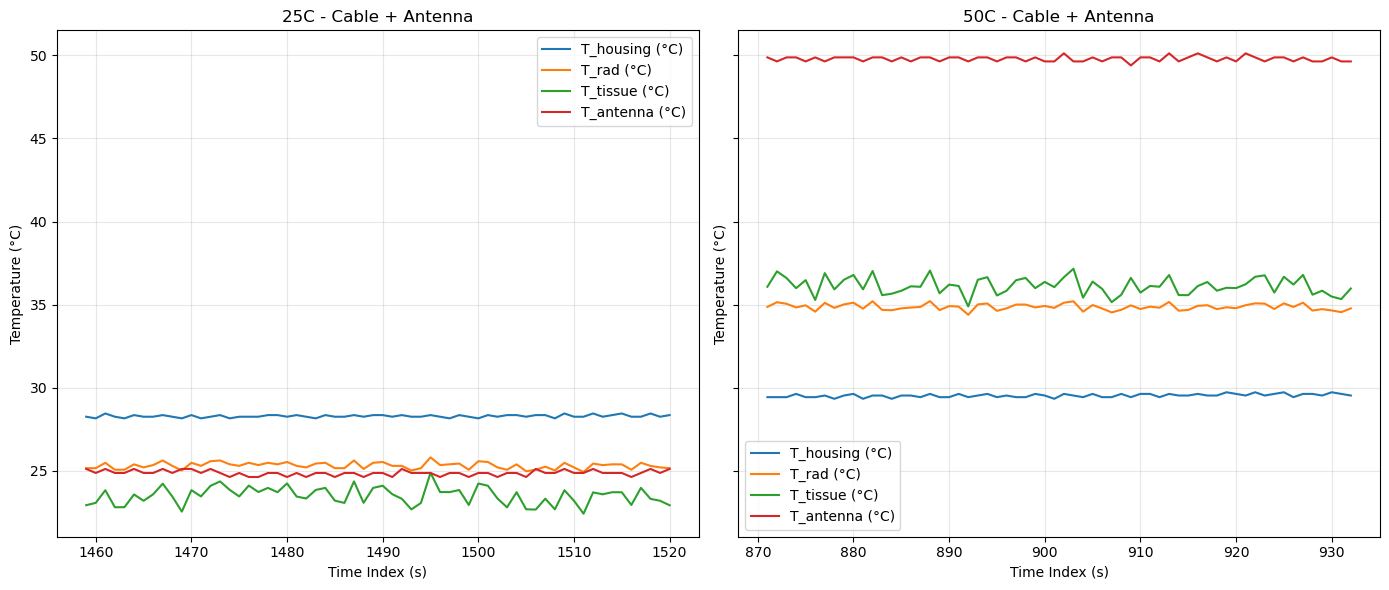

In [359]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_vars = ['T_housing', 'T_rad', 'T_tissue', 'T_antenna']
plot_labels = ['T_housing (°C)', 'T_rad (°C)', 'T_tissue (°C)', 'T_antenna (°C)', 'T_cable (°C)']

for i, cond in enumerate(conditions):
    ax = axes[i]
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'cable+antenna')
    df_cond = all_X_clean[mask]
    for var, label in zip(plot_vars, plot_labels):
        ax.plot(df_cond['time_index'], df_cond[var].astype(float), label=label)
    ax.set_title(f"{cond} - Cable + Antenna")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [360]:
for cond in conditions:
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'cable+antenna+cooling')
    df_cable_antenna = all_X_clean[mask]
    if len(df_cable_antenna) == 0:
        continue
    V_spike = df_cable_antenna['V_spike'].values / 1000
    V_rad_tot = df_cable_antenna['V_rad_tot'].values / 1000
    V_housing = df_cable_antenna['V_housing'].values / 1000
    V_cable = df_cable_antenna['V_cable'].values / 1000 if 'V_cable' in df_cable_antenna.columns else V_housing

    T_housing = T_housing_func(V_housing)
    T_rad = T_rad_func(V_rad_tot, T_housing)
    T_antenna = T_antenna_func(V_spike)
    T_tissue = T_tissue_cable_antenna_func(T_rad, T_antenna)

    # Update all_X_clean columns
    all_X_clean.loc[mask, 'T_rad'] = T_rad
    all_X_clean.loc[mask, 'T_tissue'] = T_tissue
    all_X_clean.loc[mask, 'T_housing'] = T_housing
    all_X_clean.loc[mask, 'T_antenna'] = T_antenna

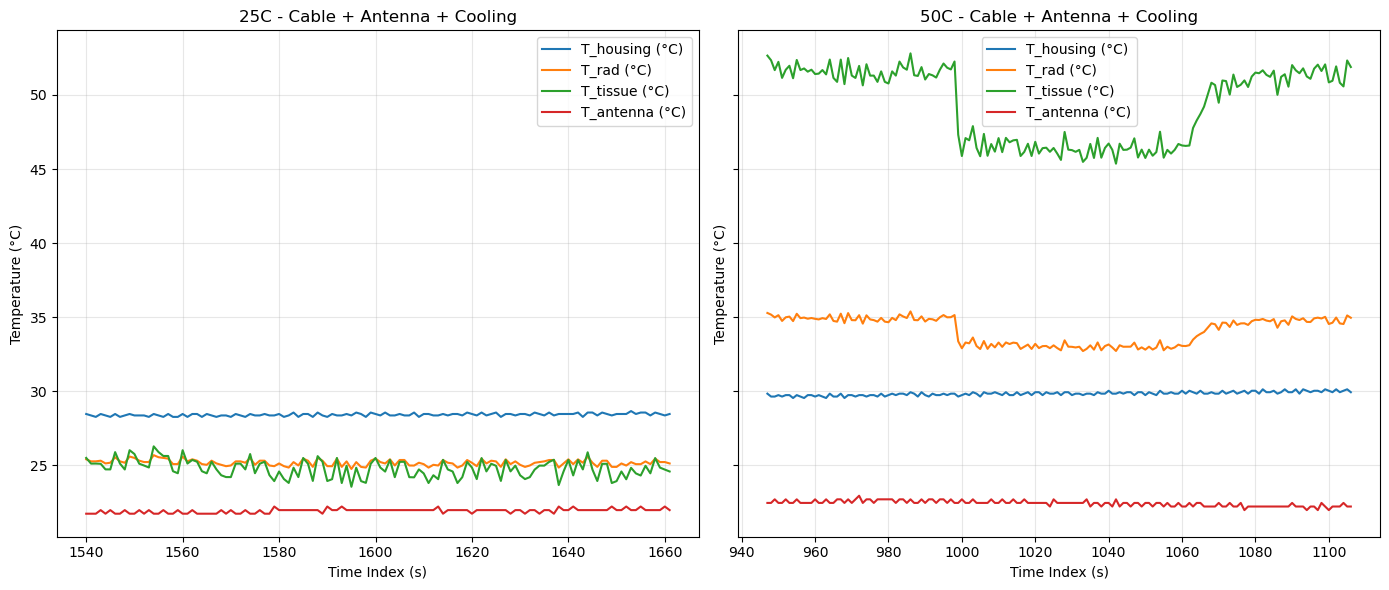

In [361]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plot_vars = ['T_housing', 'T_rad', 'T_tissue', 'T_antenna']
plot_labels = ['T_housing (°C)', 'T_rad (°C)', 'T_tissue (°C)', 'T_antenna (°C)', 'T_cable (°C)']

for i, cond in enumerate(conditions):
    ax = axes[i]
    mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == 'cable+antenna+cooling')
    df_cond = all_X_clean[mask]
    for var, label in zip(plot_vars, plot_labels):
        ax.plot(df_cond['time_index'], df_cond[var].astype(float), label=label)
    ax.set_title(f"{cond} - Cable + Antenna + Cooling")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Condition 25C - Data summary by class:
  open: 65 points, time range: 0.0 - 64.0 s
  load: 65 points, time range: 85.0 - 149.0 s
  antenna: 65 points, time range: 170.0 - 234.0 s
  cable+load: 66 points, time range: 255.0 - 320.0 s
  cable+antenna: 62 points, time range: 341.0 - 402.0 s
  antenna+cooling: 129 points, time range: 423.0 - 551.0 s
  cable+antenna+cooling: 122 points, time range: 572.0 - 693.0 s

Condition 50C - Data summary by class:
  open: 62 points, time range: 0.0 - 61.0 s
  load: 61 points, time range: 82.0 - 142.0 s
  antenna: 62 points, time range: 163.0 - 224.0 s
  cable+load: 62 points, time range: 245.0 - 306.0 s
  cable+antenna: 62 points, time range: 327.0 - 388.0 s
  antenna+cooling: 142 points, time range: 409.0 - 550.0 s
  cable+antenna+cooling: 160 points, time range: 571.0 - 730.0 s


/var/folders/ck/m95myx7x7575w886yq8txthr0000gn/T/ipykernel_28597/1278941985.py:85: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time, alpha=0.1, color='blue',
/var/folders/ck/m95myx7x7575w886yq8txthr0000gn/T/ipykernel_28597/1278941985.py:85: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(start_time, end_time, alpha=0.1, color='blue',


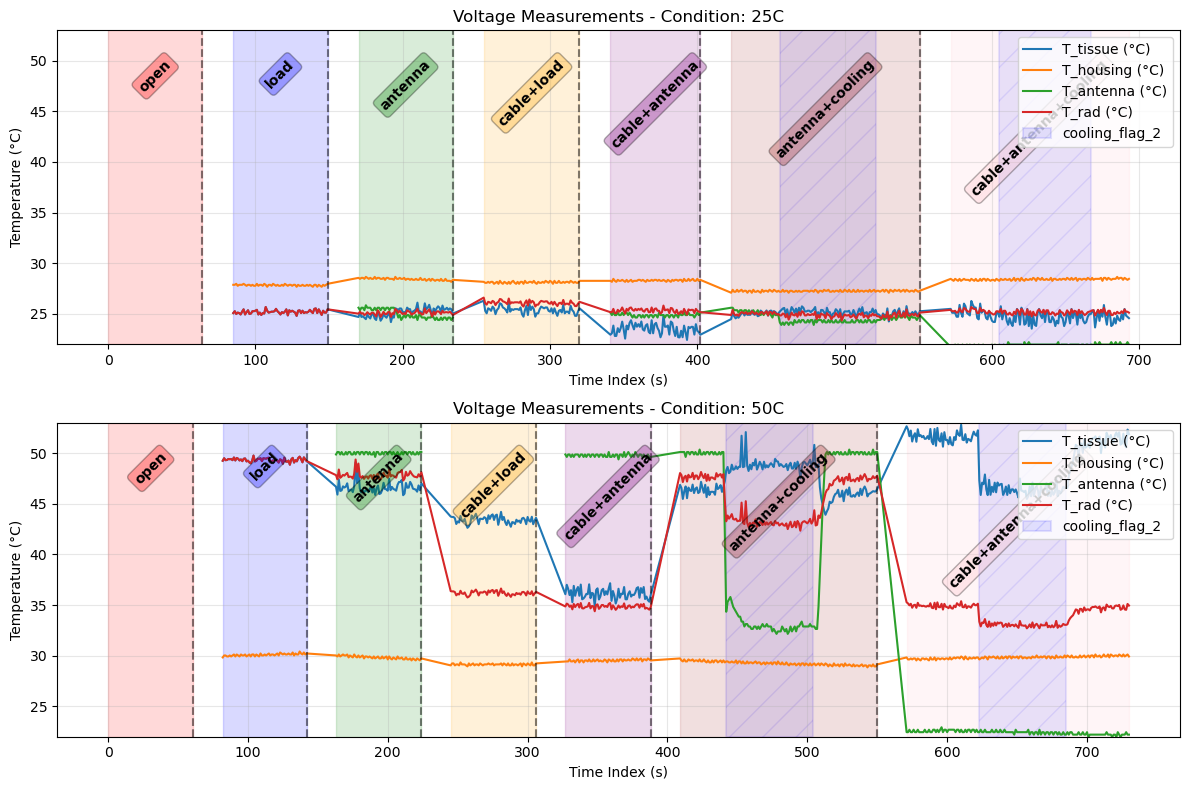

In [362]:
# Define class order and colors
class_order = ['open', 'load', 'antenna', 'cable+load', 'cable+antenna', 'antenna+cooling', 'cable+antenna+cooling']
class_colors = {
    'open': 'red',
    'load': 'blue', 
    'antenna': 'green',
    'cable+load': 'orange',
    'cable+antenna': 'purple',
    'antenna+cooling': 'brown',
    'cable+antenna+cooling': 'pink'
}

# Define voltage variables to plot
# variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
variables = ['T_tissue', 'T_housing', 'T_antenna', 'T_rad']
labels = {
    'T_tissue': 'T_tissue (°C)',
    'T_housing': 'T_housing (°C)',
    'T_antenna': 'T_antenna (°C)',
    'T_rad': 'T_rad (°C)'
}

# Get unique conditions
conditions = sorted(all_X_clean['condition'].unique())

# Create subplots for each condition
fig, axes = plt.subplots(len(conditions), 1, figsize=(6 * len(conditions), 8))
axes[0].set_ylim(22, 53)
axes[1].set_ylim(22, 53)
plt.ylim(22, 53)
if len(conditions) == 1:
    axes = [axes]

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    
    # Filter data for this condition
    condition_data = all_X_clean[all_X_clean['condition'] == condition].copy()
    
    # Get available classes for this condition in order
    available_classes = [cls for cls in class_order if cls in condition_data['class'].unique()]
    
    # Create new time index with gaps between classes
    gap_duration = 20  # seconds between each class
    condition_data['time_index_2'] = 0.0
    current_time = 0
    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name].copy()
        
        if len(class_data) > 0:
            # Sort by original time_index to maintain chronological order
            class_data = class_data.sort_values('time_index')
            
            # Create new continuous time index for this class
            duration = len(class_data)
            new_time_indices = np.arange(current_time, current_time + duration)
            
            # Update the condition dataframe
            mask = condition_data['class'] == class_name
            condition_data.loc[mask, 'time_index_2'] = new_time_indices
            
            # Update current_time for next class (add duration + gap)
            current_time += duration + gap_duration
    
    # Sort data by time_index_2 for proper plotting
    data_sorted = condition_data.sort_values('time_index_2')
    
    # Plot each voltage variable
    for var in variables:
        ax.plot(data_sorted['time_index_2'], data_sorted[var], label=labels[var])
    
    # Add blue shaded dashed areas for cooling_flag_2 == 1
    cooling_flag_2_data = data_sorted[data_sorted['cooling_flag_2'] == 1]
    if len(cooling_flag_2_data) > 0:
        # Group consecutive cooling periods
        cooling_flag_2_data = cooling_flag_2_data.copy()
        cooling_flag_2_data['group'] = (cooling_flag_2_data['time_index_2'].diff() > 1).cumsum()
        
        for group_id, group_data in cooling_flag_2_data.groupby('group'):
            start_time = group_data['time_index_2'].min()
            end_time = group_data['time_index_2'].max()
            
            # Add blue shaded area with dashed edges
            ax.axvspan(start_time, end_time, alpha=0.1, color='blue', 
                      edgecolor='blue', linewidth=1.5, hatch="/",
                      label='cooling_flag_2' if group_id == cooling_flag_2_data['group'].iloc[0] else "")
    
    # Add background colors and labels for each class    
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            class_start = class_data['time_index_2'].min()
            class_end = class_data['time_index_2'].max()
            
            # Add background color for each class
            ax.axvspan(class_start, class_end, alpha=0.15, color=class_colors[class_name])
            
            # Add vertical line at the end of each class (except the last one)
            if class_name != available_classes[-1]:
                ax.axvline(class_end, color='black', linestyle='--', alpha=0.5)
            
            # Add text annotation for class name
            class_center = (class_start + class_end) / 2
            ax.text(class_center, ax.get_ylim()[1] * 0.95, class_name, 
                    ha='center', va='top', fontweight='bold', rotation=45,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=class_colors[class_name], alpha=0.3))
    
    ax.set_title(f"Voltage Measurements - Condition: {condition}")
    ax.set_xlabel("Time Index (s)")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Print summary for this condition
    print(f"\nCondition {condition} - Data summary by class:")
    for class_name in available_classes:
        class_data = condition_data[condition_data['class'] == class_name]
        if len(class_data) > 0:
            time_range = f"{class_data['time_index_2'].min():.1f} - {class_data['time_index_2'].max():.1f} s"
            print(f"  {class_name}: {len(class_data)} points, time range: {time_range}")

plt.tight_layout()
plt.show()